# Analysis of Social and Planetary Boundaries: A Doughnut Economics Perspective

## Introduction

This notebook will conduct a comprehensive analysis of global social shortfalls and ecological overshoots using the Doughnut Economics framework. The Doughnut model conceptualizes a safe and just space for humanity, bounded by:

- **Social Foundation (inner boundary)**: The minimum standards for human well-being across 12 dimensions
- **Ecological Ceiling (outer boundary)**: The planetary boundaries that must not be exceeded across 9 dimensions

## Analysis

We will proceed through the following steps:


1. **Summary Statistics**: 
   - Social shortfall values for the first and last years
   - Ecological overshoot values for the first and last years
2. **Income Group Analysis**: Analyze disparities across income groups (Bottom-40%, Middle-40%, Top-20%) using trellis plots to visualize:
   - Ecological overshoot patterns by income group
   - Social shortfall patterns by income group

3. **Global Change Analysis**: Create a "sandwich plot" visualization showing:
   - Changes in ecological overshoot from 2000-2001 to 2021-2022
   - Changes in social shortfall over the same period

4. **Doughnut Chart Visualization**: Create a  doughnut chart that simultaneously visualizes both the social foundation  and ecological ceiling, providing an  view of the current global status of shortfall and overshoot.

This analysis is based on the dataset published by [Fanning et al. (2025)](https://www.nature.com/articles/s41586-025-09385-1) and follows their methodology for calculating shortfalls and overshoots relative to the social foundation and ecological ceiling boundaries.

First we have to fetch the data used in paper for the analysis

In [1332]:
import requests

url = "https://zenodo.org/records/15688962/files/a-fanning/doughnut-v3-v1.0.1.zip?download=1"
zip_path = "doughnut-v3-v1.0.1.zip"

response = requests.get(url)
response.raise_for_status()

with open(zip_path, "wb") as f:
    f.write(response.content)

print("Downloaded:", zip_path)

Downloaded: doughnut-v3-v1.0.1.zip


In [1333]:
import zipfile
from pathlib import Path

zip_path = Path("doughnut-v3-v1.0.1.zip")
extract_dir = Path("doughnut-v3")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted to:", extract_dir.resolve())

for p in extract_dir.rglob("*"):
    print(p)

Extracted to: D:\aueb_machine_learning\ex1\doughnut-v3
doughnut-v3\a-fanning-doughnut-v3-a0460e5
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final
doughnut-v3\a-fanning-doughnut-v3-a0460e5\README.md
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\myData
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\scripts
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\001_nationalGNIperCap-Population_2000-2022_n193.csv
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\eco-1_climateChange_clean.csv
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\eco-2_oceanAcid_clean.csv
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\eco-3_chemPollution_clean.csv
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\eco-4_nutrientPollution_clean.csv
doughnut-v3\a-fanning-doughnut-v3-a0460e5\Analysis-Final\cleanData\eco-5_freshwaterDisrupti

## 2. Data Loading and Preprocessing

### 2.1 Loading Clean Data Files

We begin by loading all cleaned indicator data files from the `cleanData` directory. Each file contains time series data for a specific indicator (either social or ecological dimension).


In [1334]:
import pandas as pd
from pathlib import Path

base_dir = Path("doughnut-v3") / "a-fanning-doughnut-v3-a0460e5" / "Analysis-Final"
clean_dir = base_dir / "cleanData"

In [1335]:
full_files =  sorted(clean_dir.glob("*_clean.csv"))

In [1336]:
global_list = [pd.read_csv(f) for f in full_files]
global_data= pd.concat(global_list, ignore_index=True)

To continue the analysis we have to construct a dataframe containing for each indicator and date the overshoot/shortfall according to the global baseline and boundary.

### 2.1 Transforming the data

Some indicators require special preprocessing to match the way results are conceptually defined and presented in the paper.

---

#### 1. Inverting Indicators (from access → shortfall)

Many social indicators in the raw dataset are expressed as access, coverage, or achievement.  


Because many raw indicators are given as *access* rather than *deprivation*, we convert them using:

```
shortfall = 1 - access_rate
```

---

#### 2. Multiplying by 100 (fractions → percentages)

The paper reports all shortfall and overshoot values in percentage units.  
Since many raw indicators appear as fractions between 0 and 1, we scale them to percentages:

```
percent = value * 100
```

In [1337]:
invert = [
    "internet",
    "publicTrans",
    "adultLiteracy",
    "secondarySchool",
    "energyAccess",
    "energyIndoor",
    "cleanFuel",
    "vaccinations",
    "sanitation",
    "drinkingH2O",

]

global_data.loc[
    global_data["indicator"].isin(invert),
    "value"
] = 100 - global_data.loc[
    global_data["indicator"].isin(invert),
    "value"
]

In [1338]:
multiply_100 = [
    "genderGapIndex",
    "societalPoverty"
]
global_data.loc[
    global_data["indicator"].isin(multiply_100),
    "value"
] = 100 * global_data.loc[
    global_data["indicator"].isin(multiply_100),
    "value"
]


### 2.3 Boundary Assignment

In order to caclulate the overshoot and shortfall values, we have to now the boundary for each indicator.
Boundaries, which can be found in the `/myData/4_20250108_doughnutData-boundaries.csv` file.

Boundaries are merged with the indicator data to enable calculation of shortfalls and overshoots.


In [1339]:
# fetch boundaries for all indicators
boundaries_df = pd.read_csv(
    "doughnut-v3\\a-fanning-doughnut-v3-a0460e5\\Analysis-Final\\myData\\4_20250108_doughnutData-boundaries.csv"
)

boundaries_global = boundaries_df[
    (boundaries_df["type"] == "global doughnut") &
    (boundaries_df["group"] == "World") &
    (boundaries_df["boundary"].notna())
].copy()

boundaries_national = boundaries_df[
    (boundaries_df["type"] == "national aggregate") &
    (boundaries_df["date"] == 2017) &
    (boundaries_df["boundary"].notna())
].copy()

In [1340]:
boundaries_lookup_global = boundaries_global[["indicator", "boundary"]].drop_duplicates(subset=["indicator"])
boundaries_lookup_national = boundaries_national[["indicator", "boundary"]].drop_duplicates(subset=["indicator"])

# create a table to link boundaries to indicators
boundaries_lookup = pd.concat([
    boundaries_lookup_global,
    boundaries_lookup_national
], ignore_index=True).drop_duplicates(subset=["indicator"])
boundaries_lookup["indicator"] = boundaries_lookup["indicator"].replace({
    "chemicalsMt_Hzd": "chemicalsMt"
})

In [1341]:
if "boundary" in global_data.columns:
    global_data = global_data.drop(columns=["boundary"])

# merge data with boundaries
global_data = global_data.merge(
    boundaries_lookup,
    on=["indicator"],
    how="left"
)

total_rows = len(global_data)
rows_with_boundaries = global_data['boundary'].notna().sum()
unique_indicators = global_data['indicator'].nunique()
indicators_with_boundaries = global_data[global_data['boundary'].notna()]['indicator'].nunique()


indicators_without = global_data[global_data['boundary'].isna()]['indicator'].unique()
if len(indicators_without) > 0:
    print(f"\n  Indicators without boundaries ({len(indicators_without)}):")
    for ind in sorted(indicators_without):
        count = len(global_data[global_data['indicator'] == ind])
        print(f"    - {ind} ({count} rows)")



  Indicators without boundaries (8):
    - EUshare_hzdHealth (23 rows)
    - airPollution_footprint (92 rows)
    - hzdChemicals_footprint (92 rows)
    - inadequateHous (92 rows)
    - land_footprint (92 rows)
    - omega_a_footprint (92 rows)
    - ozone_footprint (92 rows)
    - racialInequality (92 rows)


### 2.4 Calculating Shortfalls and Overshoots

The core metric of the Doughnut framework is the percentage shortfall (for social indicators) or overshoot (for ecological indicators):

- **Social shortfall**: Directly uses the percentage of population experiencing the shortfall (e.g., 30% means 30% of population lacks access)
- **Ecological overshoot**: Calculated as `(value - boundary) / (boundary - baseline) × 100`, measuring how far beyond the safe boundary we are

**Note**: Baselines are found in the [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-025-09385-1/MediaObjects/41586_2025_9385_MOESM1_ESM.pdf) of the paper, in Table 2.


In [1342]:
ecological_baselines = {
    "co2_ppm":        280,
    "erf_wm2":        0,
    "omega_a":        3.44,
    "chemicalsMt_Hzd": 0,
    "phosphorusMt":    0,
    "nitrogenMt":      0,
    "interhemAOD":     0,
    "blueDev":         0,
    "soilDev":         0,
    "forestAreaMKM2":  0,
    "extinction1900":  1,
    "hanppGtC":        0,
    "ozoneDU":         290,
    "co2_footprint": 0,
    "omega_a_footprint": 0,
    "hzdChemicals_footprint": 0,
    "N_footprint": 0,
    "P_footprint": 0,
    "blueH2O_footprint": 0,
    "land_footprint": 0,
    "species_footprint": 0,
    "hanpp_footprint": 0,
    "airPollution_footprint": 0,
    "ozone_footprint": 0
}


In [1343]:
import numpy as np
global_data["baseline"] = global_data["indicator"].map(ecological_baselines)

# Mask to keep only ecological data with non-missing values for value, boundary, and baseline
eco_mask = (
    (global_data["domain"] == "ecological") &
    global_data["value"].notna() &
    global_data["boundary"].notna() &
    global_data["baseline"].notna()
)

# Mask to keep only social data with non-missing values for value
soc_mask = (
    (global_data["domain"] == "social") &
    global_data["value"].notna()
)


global_data["shortfallOvershoot_pct"] = np.nan


val = global_data["value"].astype(float)
bnd = global_data["boundary"].astype(float)
bsl = global_data["baseline"].astype(float)

# Calculate ecological overshoot
eco_overshoot = np.where(
    val > bnd,
    (val - bnd) / (bnd - bsl) * 100,
    0
)

global_data.loc[eco_mask, "shortfallOvershoot_pct"] = eco_overshoot[eco_mask]


global_data.loc[soc_mask, "shortfallOvershoot_pct"] = val[soc_mask]


global_data["shortfallOvershoot_pct"] = global_data["shortfallOvershoot_pct"].astype(float).round(1)

In [1344]:
global_world = global_data[global_data["group"] == "World"].copy()

global_world.head()

,domain,dimension,type,group,indicator,date,populationTotal,GNIperCap,value,boundary,baseline,shortfallOvershoot_pct
0,ecological,climate change,global doughnut,World,co2_ppm,2000,NaN,NaN,368.96,350.0,280.0,27.1
1,ecological,climate change,global doughnut,World,co2_ppm,2001,NaN,NaN,370.57,350.0,280.0,29.4
2,ecological,climate change,global doughnut,World,co2_ppm,2002,NaN,NaN,372.58,350.0,280.0,32.3
3,ecological,climate change,global doughnut,World,co2_ppm,2003,NaN,NaN,375.14,350.0,280.0,35.9
4,ecological,climate change,global doughnut,World,co2_ppm,2004,NaN,NaN,376.95,350.0,280.0,38.5


We now have Shortfall/Overshoot for everyindicator on each year.

## 3. Summary Statistics

### 3.1 Social Indicators Summary

We examine the temporal coverage and values for each social indicator, showing:
- First and last available dates
- First and last values


In [1345]:
social_df = global_world[
    global_world["domain"] == "social"
].copy()

social_df = social_df.dropna(subset=["value"])

rows = []

for (dim, ind), g in social_df.groupby(["dimension", "indicator"]):
    # We only need first and last values per indicator
    g_sorted = g.sort_values("date")

    first_row = g_sorted.iloc[0]
    first_year = int(first_row["date"])
    first_val  = round(first_row["value"], 2)

    last_row = g_sorted.iloc[-1]
    last_year = int(last_row["date"])
    last_val  = round(last_row["value"], 2)

    rows.append({
        "dimension": dim,
        "indicator": ind,
        "date_first_nonNA": first_year,
        "date_last_nonNA": last_year,
        "value_first_nonNA": first_val,
        "value_last_nonNA": last_val,
    })

social_summary = (
    pd.DataFrame(rows)
    .sort_values(["dimension", "indicator"])
    .reset_index(drop=True)
)

In [1346]:
table1_df = social_summary.copy()

# Rename columns to match paper style
table1_df = table1_df.rename(columns={
    "dimension": "dimension",
    "indicator": "indicator",
    "date_first_nonNA": "first_date",
    "date_last_nonNA": "last_date",
    "value_first_nonNA": "first_value",
    "value_last_nonNA": "last_value"
})

table1_df["dimension"] = table1_df["dimension"].str.capitalize()


In [1347]:
indicator_desc = {
    "internet": "Population not accessing the internet",
    "publicTrans": "Urban population lacking convenient access to public transport",
    "adultLiteracy": "Adult population (aged 15+ years) who are illiterate",
    "secondarySchool": "Young adult population (aged 21–23 years) with incomplete upper secondary education",
    "energyAccess": "Population lacking access to electricity",
    "energyIndoor": "Population lacking access to clean fuels and technologies for cooking, heating and lighting",
    "genderGapIndex": "Population-weighted score on the Gender Inequality Index (global gap in reproductive health, empowerment and employment)",
    "foodInsecurity": "Population with moderate to severe food insecurity",
    "undernourishment": "Population undernourished",
    "UHCindex": "Population living in countries without high coverage of essential health services (Universal Health Coverage Index score less than 60 out of 100)",
    "under5death": "Population living in countries with under-5 mortality rate exceeding 25 per 1,000 live births",
    "urbanSlums": "Urban population living in slums or informal settlements",
    "societalPoverty": "Population living below the societal poverty line, set at half their country's median household income or at least $15 a day",
    "youthNEET": "Population of young people (aged 15–24 years) not in employment, education or training",
    "controlCorruption": "Population stating that they perceive widespread corruption in government and business",
    "homicideOver5": "Population living in countries with a homicide rate of 5 or more per 100,000",
    "govRegimes": "Population living in countries governed by an autocratic regime",
    "palma": "Population living in countries with a Palma ratio of 2 or more (the income share of the richest 10% of people relative to the poorest 40%)",
    "socialSupport": "Population stating that they are without someone to count on in times of trouble",
    "drinkingH2O": "Population lacking access to safely managed drinking water",
    "sanitation": "Population lacking access to safely managed sanitation"
}
# Use appropriate desceriptions for the indicators
table1_df["indicator"] = table1_df["indicator"].replace(indicator_desc)


In [1348]:
table1_df = table1_df[[
    "dimension",
    "indicator",
    "first_date",
    "last_date",
    "first_value",
    "last_value"
]]


In [1349]:
# Format the table
table1_df.columns = pd.MultiIndex.from_tuples([
    ("dimension", ""),
    ("indicator", ""),
    ("date", "first"),
    ("date", "last"),
    ("value", "first"),
    ("value", "last")
])


In [1350]:
# Style adnd display table
styled_social = (
    table1_df.style
    .set_properties(**{
        "text-align": "left",
        "white-space": "normal",
        "border": "1px solid #444"
    })
    .set_table_styles([
        dict(selector="th", props=[("text-align", "center"), ("border", "1px solid #444")])
    ])
    .format({
        ("value", "first"): "{:.2f}",
        ("value", "last"):  "{:.2f}"
    })
)

styled_social

### 3.2 Ecological Indicators Summary

Similarly, we examine ecological indicators. Note that ecological indicators use different units and scales, so the raw values represent different physical quantities (e.g., CO₂ in ppm, nitrogen in Mt/year).



In [1351]:
# Keep only ecological indicators
eco_df = global_world[
    global_world["domain"] == "ecological"
].copy()

eco_df = eco_df.dropna(subset=["value"])

rows = []
# For each indicator fetch first and last values
for (dim, ind), g in eco_df.groupby(["dimension", "indicator"]):

    g_sorted = g.sort_values("date")

    first_row = g_sorted.iloc[0]
    first_year = int(first_row["date"])
    first_val  = round(first_row["value"], 2)

    last_row = g_sorted.iloc[-1]
    last_year = int(last_row["date"])
    last_val  = round(last_row["value"], 2)

    rows.append({
        "dimension": dim,
        "indicator": ind,
        "date_first_nonNA": first_year,
        "date_last_nonNA": last_year,
        "value_first_nonNA": first_val,
        "value_last_nonNA": last_val,
    })
eco_summary = (
    pd.DataFrame(rows)
    .sort_values(["dimension", "indicator"])
    .reset_index(drop=True)
)

In [1352]:
eco_indicator_desc = {
    "interhemAOD": (
        "Arithmetic Error Asymmetry between Earth's hemispheres of sunlight "
        "reaching the surface, owing to differences in atmospheric particle "
        "concentration (at most 0.1 inter-hemispheric difference in Aerosol Optical Depth)"
    ),

    "extinction1900": (
        "Rate of species extinctions per million species years (at most 10 E/MSY)"
    ),
    "hanppGtC": (
        "Human appropriation of net primary productivity, billions of tonnes of carbon "
        "per year (at most 10% of 55.9 Gt C)"
    ),

    "chemicalsMt": (
        "Production of hazardous chemicals, millions of tonnes per year "
        "(at most 5% of the 1,200 Mt of total chemicals produced in year 2000)"
    ),

    "co2_ppm": (
        "Atmospheric carbon dioxide concentration, parts per million "
        "(at most 350 ppm CO₂)"
    ),
    "erf_wm2": (
        "Human-induced radiative forcing at the top of the atmosphere, W/m² "
        "(at most 1 W m⁻²)"
    ),

    "blueDev": (
        "Proportion of land area with human-induced disturbance of blue-water flow "
        "deviating from Holocene variability (at most 10.2%)"
    ),
    "soilDev": (
        "Proportion of land area with root-zone soil moisture deviating from "
        "Holocene variability (at most 11.1%)"
    ),

    "forestAreaMKM2": (
        "Area of forested land as a proportion of forest-covered land before "
        "human alteration (at least 75% of 64 million km²)"
    ),

    "nitrogenMt": (
        "Nitrogen applied to land as fertilizer, millions of tonnes per year "
        "(at most 62 Mt/year)"
    ),
    "phosphorusMt": (
        "Phosphorus applied to land as fertilizer, millions of tonnes per year "
        "(at most 6.2 Mt/year)"
    ),

    "omega_a": (
        "Average saturation state of aragonite at the ocean surface "
        "(at least 80% of pre-industrial saturation state of 3.44 Ωarag)"
    ),

    "totalOzone": (
        "Concentration of ozone in the stratosphere, Dobson units "
        "(at most 5% decrease with respect to 1964–1980 value of 290 DU)"
    ),
}


In [1353]:
table2_df = eco_summary.copy()

# Capitalize dimensions
table2_df["dimension"] = table2_df["dimension"].str.replace("_", " ").str.capitalize()

# Keep only indicators that exist in the dictionary
table2_df = table2_df[table2_df["indicator"].isin(eco_indicator_desc.keys())].reset_index(drop=True).copy()

# Then replace with the long definitions
table2_df["indicator"] = table2_df["indicator"].replace(eco_indicator_desc)

# Rename accorsing to paper
table2_df = table2_df.rename(columns={
    "date_first_nonNA": "first_date",
    "date_last_nonNA": "last_date",
    "value_first_nonNA": "first_value",
    "value_last_nonNA": "last_value"
})

# Round values
table2_df[["first_value", "last_value"]] = table2_df[["first_value", "last_value"]].round(2)

# Reorder like the paper
table2_df = table2_df[[
    "dimension",
    "indicator",
    "first_date", "last_date",
    "first_value", "last_value"
]]


In [1354]:
table2_df.columns = pd.MultiIndex.from_tuples([
    ("dimension", ""),
    ("indicator", ""),
    ("date", "first"),
    ("date", "last"),
    ("value", "first"),
    ("value", "last"),
])


In [1355]:
# Style and display table
styled_eco = (
    table2_df.style
    .set_properties(**{
        "text-align": "left",
        "white-space": "normal",
        "border": "1px solid #444"
    })
    .set_table_styles([
        dict(selector="th", props=[("text-align", "center"), ("border", "1px solid #444")])
    ])
    .format({
        ("value", "first"): "{:.2f}",
        ("value", "last"):  "{:.2f}"
    })
)

styled_eco


## 4. Income Group Analysis: Trellis Plots

### 4.1 Data Preparation for Income Groups

We analyze data for three income groups based on population-weighted GNI per capita:
- **Bottom-40**: Bottom 40% of global population by income
- **Middle-40**: Middle 40% of global population by income  
- **Top-20**: Top 20% of global population by income

Data is filtered for 2017 (or 2020 for specific indicators like public transport) to enable cross-group comparisons at a single point in time.


In [1356]:
global_data["group"].unique()

array(['World', 'Bottom-40', 'Middle-40', 'Top-20'], dtype=object)

From the global dataframe, we keep only the observations for the Bottom40, Middle40, and Top20 country groups for 2017. The only exception is the public-transport indicator, where 2020 is used due to the lack of earlier data, as stated in the paper.

In [1357]:
clusters = ["Bottom-40", "Middle-40", "Top-20"]

income_groups_df = global_data[
    ((global_data["date"] == 2017) &
    (global_data["group"].isin(clusters)) |( global_data["indicator"] == "publicTrans") &
    (global_data["date"] == 2020))
].copy()

### 4.2 Ecological Overshoot Trellis Plot

We start by investigating the ecological overshoot.
The trellis plot displays ecological overshoot for six key footprint indicators across the three income groups. Each panel shows a different indicator, allowing us to compare:
- Which income groups contribute most to each type of overshoot
- The relative magnitude of different ecological pressures.


We start by filtering the global dataframe to keep only the ecological data, and remove values that are not available.

In [1358]:
# We only need ecological data
eco_df = income_groups_df[income_groups_df["domain"] == "ecological"]

# Only keep indicators wioth values
eco_df = eco_df[eco_df["shortfallOvershoot_pct"].notna()]

eco_df = eco_df.reset_index(drop=True)

In [1359]:
eco_df["indicator"].unique()

array(['co2_footprint', 'N_footprint', 'P_footprint', 'blueH2O_footprint',
       'species_footprint', 'hanpp_footprint'], dtype=object)

We have available overshoot values for 6 different ecological indicators.

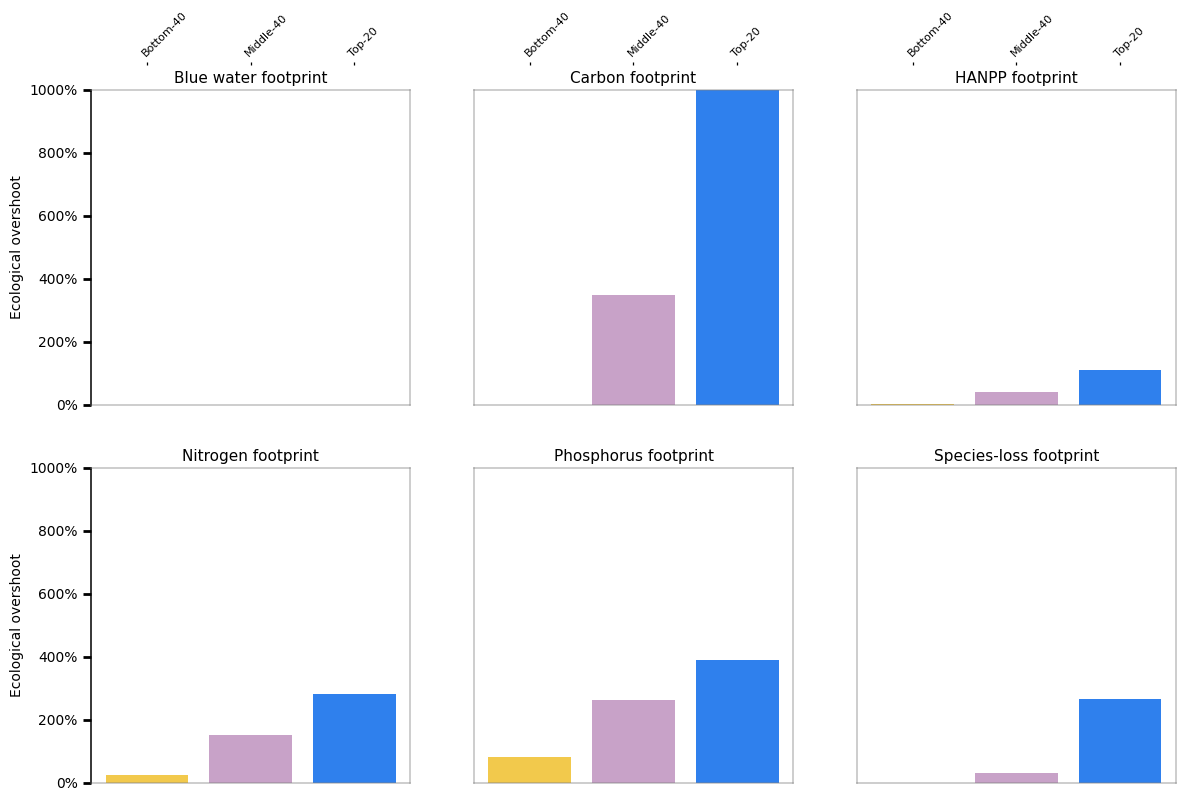

In [1360]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

clusters = ["Bottom-40", "Middle-40", "Top-20"]

colors = {
    "Bottom-40": "#F2C94C",
    "Middle-40": "#C8A2C8",
    "Top-20":    "#2F80ED",
}

# Map indicators to names
indicators = [
    ("blueH2O_footprint", "Blue water footprint"),
    ("co2_footprint",     "Carbon footprint"),
    ("hanpp_footprint",   "HANPP footprint"),
    ("N_footprint",       "Nitrogen footprint"),
    ("P_footprint",       "Phosphorus footprint"),
    ("species_footprint", "Species-loss footprint"),
]
percent_fmt = FuncFormatter(lambda x, pos: f"{int(x)}%")

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for i, (ax, (code, title)) in enumerate(zip(axes, indicators)):
    row = i // 3
    col = i % 3

    for side, spine in ax.spines.items():
        spine.set_visible(True)
        if col == 0 and side == "left":
            spine.set_linewidth(1.1)
            spine.set_color("black")
            spine.set_alpha(1.0)
        else:
            spine.set_linewidth(1.1)
            spine.set_color("gray")
            spine.set_alpha(0.5)

    ax.yaxis.set_major_formatter(percent_fmt)

    if col == 0:
        ax.yaxis.tick_left()
        ax.tick_params(labelleft=True, labelright=False)
    else:
        ax.tick_params(labelleft=False, labelright=False)

    ax.tick_params(axis="both", which="both", length=0)

    if col == 0:
        ax.tick_params(
            axis="y",
            which="both",
            left=True,
            right=False,
            length=6,
            width=2,
        )
    else:
        ax.tick_params(axis="y", left=False, right=False)

    sub = eco_df[eco_df["indicator"] == code]
    vals = [sub.loc[sub["group"] == g, "shortfallOvershoot_pct"].iloc[0]
            for g in clusters]

    x_pos = np.arange(len(clusters))
    ax.bar(x_pos, vals, color=[colors[g] for g in clusters])
    ax.set_ylim(0, 1000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis="x", bottom=False, top=False)

    if row == 0:
        ylim = ax.get_ylim()
        y_top = ylim[1]
        dy = (ylim[1] - ylim[0]) * 0.045

        for xx, lab in zip(x_pos, clusters):
            ax.text(
                xx, y_top + 2.2 * dy,
                lab,
                rotation=45,
                ha="left",
                va="bottom",
                rotation_mode="anchor",
                fontsize=8,
                clip_on=False,
            )

            ax.plot(
                [xx, xx],
                [y_top + 1.7 * dy, y_top + 1.95 * dy],
                lw=0.9,
                color="black",
                solid_capstyle="butt",
                clip_on=False,
            )

    pos = ax.get_position()

    title_ax = fig.add_axes([
        pos.x0,
        pos.y1,
        pos.width,
        0.04,
    ])

    title_ax.text(
        0.5, 0.1, title,
        ha="center", va="bottom", fontsize=11,
    )

    title_ax.set_axis_off()

axes[0].set_ylabel("Ecological overshoot")
axes[3].set_ylabel("Ecological overshoot")

plt.show()


As expected the countries in the Top20 cluster, display higher overshoot values.

### 4.3 Social Shortfall Trellis Plot

We conitnue by investigating the social shortfall.
The trellis plot displays social shortfall for 21 different indicators across the three income groups. Each panel shows a different indicator, allowing us to compare:
- Which income groups contribute most to each type of shortfall.
- The relative magnitude of different social pressures.

**Note:**
We now expect the Bottom40 nations to contribute more to each type of shortfall.

In [1361]:
# We need only the social data
social_df = income_groups_df[income_groups_df["domain"] == "social"]

#We only keep the indicators that have a value
social_df = social_df[social_df["shortfallOvershoot_pct"].notna()]

social_df = social_df.reset_index(drop=True)


In [1362]:
social_df["indicator"].unique()

array(['socialSupport', 'palma', 'govRegimes', 'controlCorruption',
       'homicideOver5', 'undernourishment', 'foodInsecurity',
       'under5death', 'UHCindex', 'adultLiteracy', 'secondarySchool',
       'societalPoverty', 'youthNEET', 'drinkingH2O', 'sanitation',
       'energyAccess', 'energyIndoor', 'internet', 'publicTrans',
       'urbanSlums', 'inadequateHous', 'genderGapIndex'], dtype=object)

In [1363]:
# Map indicators to names
indicators = [
    ("govRegimes",      "Autocratic regimes"),
    ("foodInsecurity",  "Food insecurity"),
    ("genderGapIndex",  "Gender inequality"),
    ("homicideOver5",   "Homicide rate"),
    ("adultLiteracy",   "Illiteracy rate"),
    ("palma",      "Income inequality"),
    ("secondarySchool", "Incomplete secondary school"),
    ("energyIndoor",    "Lack of clean fuels indoors"),
    ("energyAccess",    "Lack of electricity"),
    ("UHCindex",        "Lack of health services"),
    ("internet",        "Lack of internet"),
    ("publicTrans",     "Lack of public transport"),
    ("socialSupport",   "Lack of social support"),
    ("controlCorruption","Perceptions of corruption"),
    ("urbanSlums",      "Slums or informal housing"),
    ("societalPoverty", "Societal poverty"),
    ("under5death",     "Under-5 mortality"),
    ("undernourishment",  "Undernourished"),
    ("drinkingH2O",     "Unsafe drinking water"),
    ("sanitation",      "Unsafe sanitation"),
    ("youthNEET",       "Youth NEET"),
]

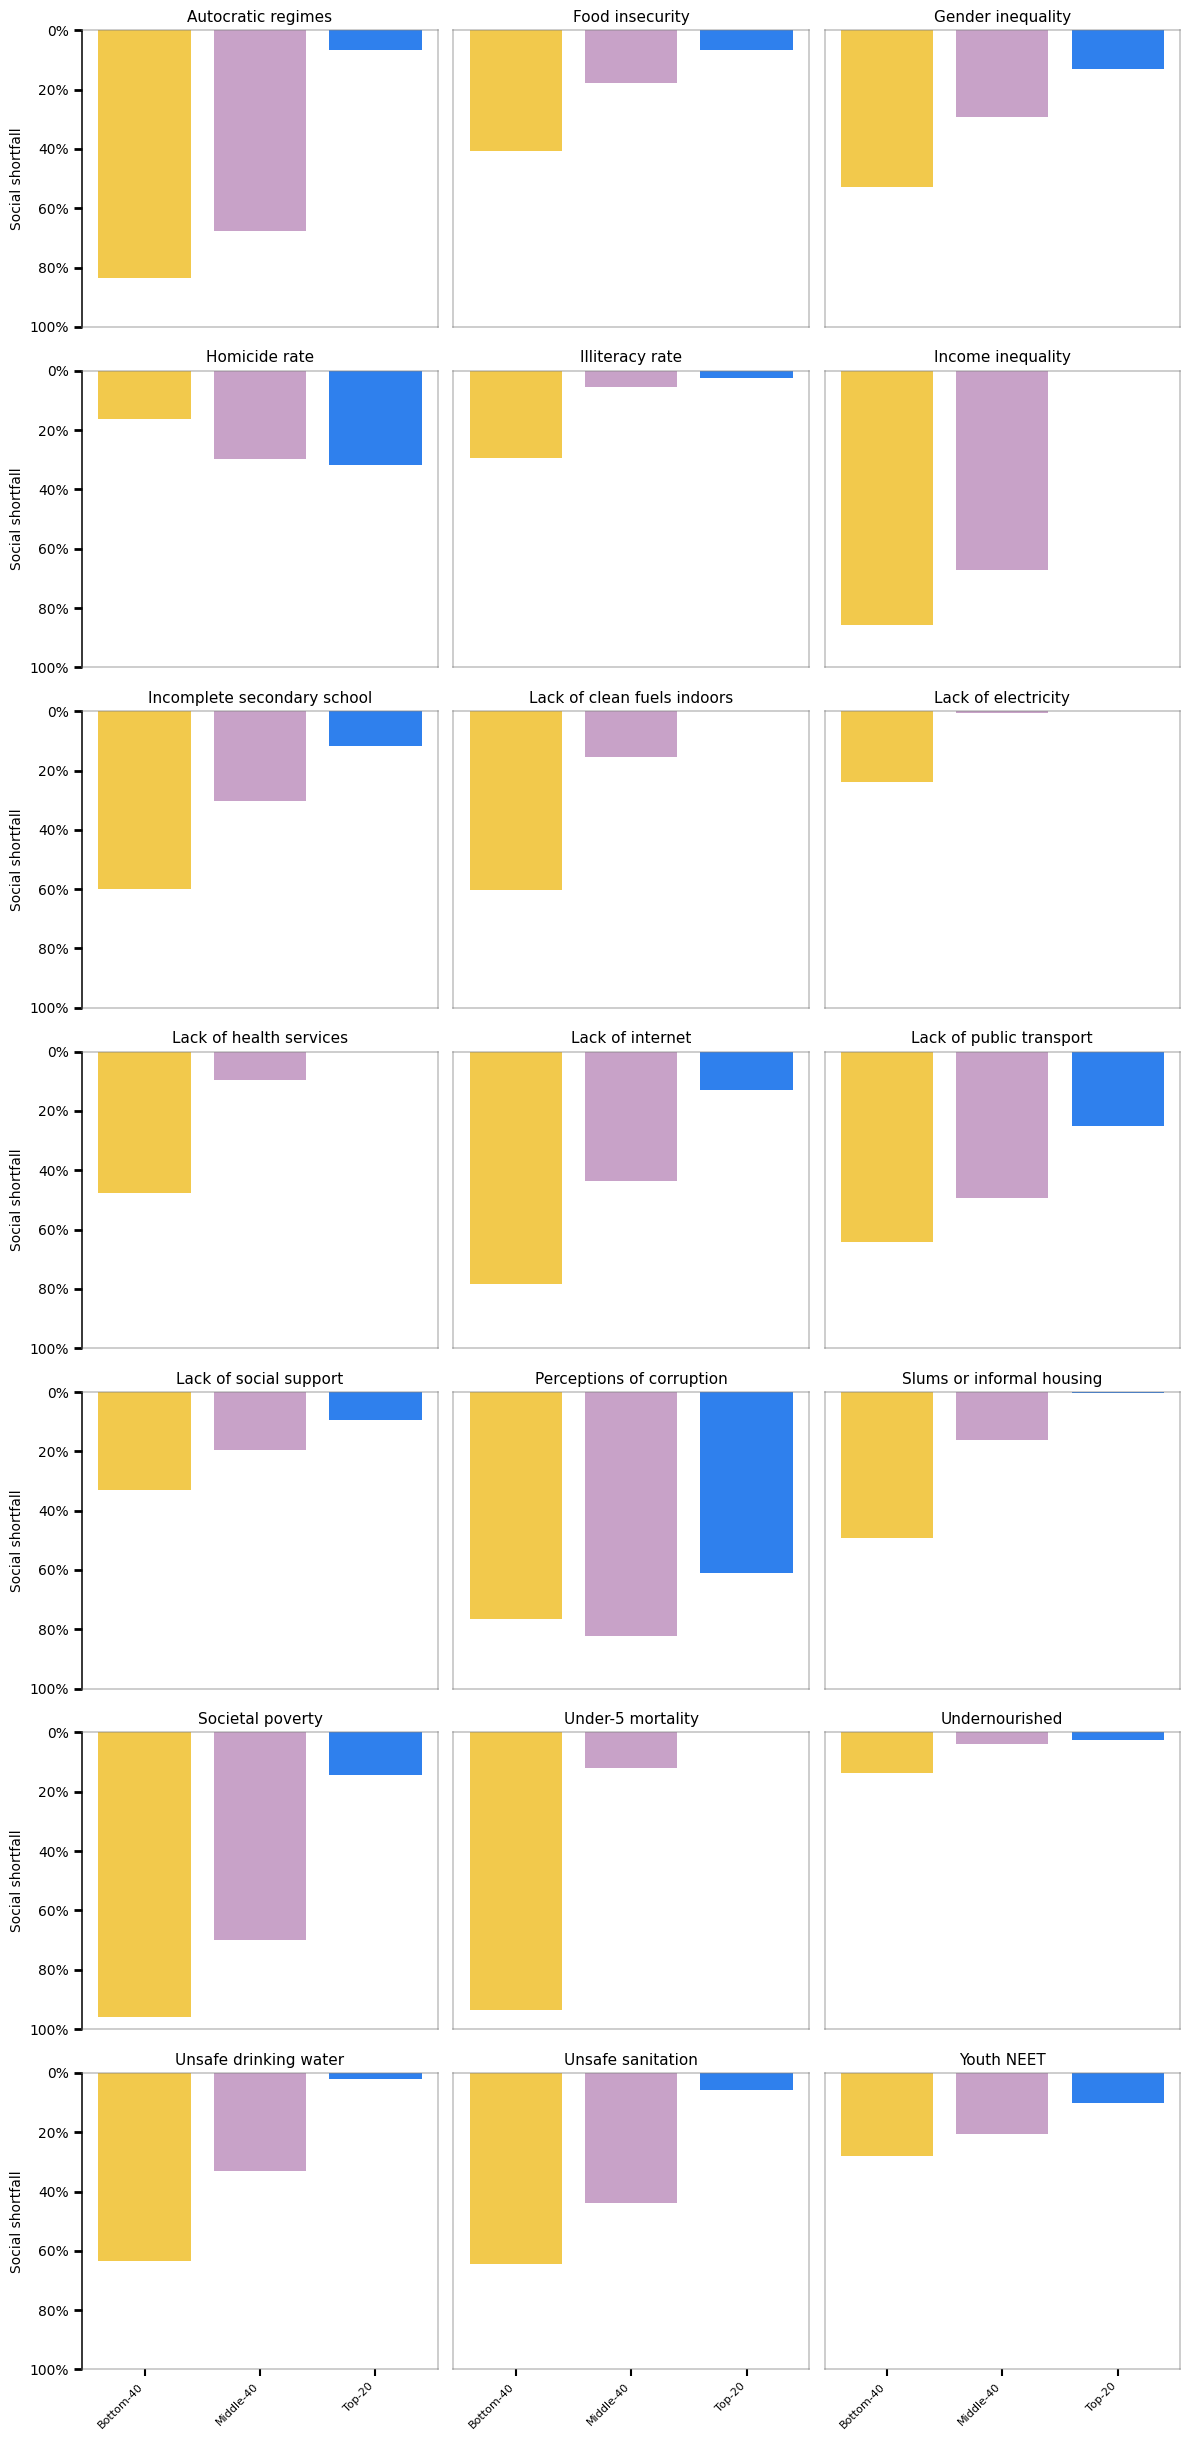

In [1364]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

clusters = ["Bottom-40", "Middle-40", "Top-20"]
colors = {
    "Bottom-40": "#F2C94C",
    "Middle-40": "#C8A2C8",
    "Top-20":    "#2F80ED",
}

percent_fmt = FuncFormatter(lambda x, pos: f"{int(x)}%")

n_ind = len(indicators)
n_cols = 3
n_rows = int(np.ceil(n_ind / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))
axes = axes.flatten()

for idx, (ax, (code, title)) in enumerate(zip(axes, indicators)):
    sub = social_df[social_df["indicator"] == code]

    vals = []
    for g in clusters:
        row = sub.loc[sub["group"] == g, "shortfallOvershoot_pct"]
        vals.append(row.iloc[0] if not row.empty else np.nan)

    ax.bar(clusters, vals, color=[colors[g] for g in clusters])

    ax.set_ylim(100, 0)
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    ax.yaxis.set_major_formatter(percent_fmt)

    col = idx % n_cols
    row = idx // n_cols

    if col == 0:
        ax.set_ylabel("Social shortfall")
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    if row == n_rows - 1:
        ax.set_xticks(range(len(clusters)))
        ax.set_xticklabels(clusters, rotation=45, ha="right", fontsize=8)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    ax.set_title(title, fontsize=11, pad=6)

    ax.tick_params(axis="both", which="both", length=0)

    if col == 0:
        ax.tick_params(
            axis="y",
            which="both",
            left=True, right=False,
            length=6, width=2,
        )
    if row == n_rows - 1:
        ax.tick_params(
            axis="x",
            which="both",
            bottom=True,
            length=5,
            width=1.5,
        )
    for side, spine in ax.spines.items():
        if col == 0 and side == "left":
            spine.set_linewidth(1.1)
            spine.set_color("black")
            spine.set_alpha(1.0)
        else:
            spine.set_linewidth(1.1)
            spine.set_color("gray")
            spine.set_alpha(0.5)

for ax in axes[n_ind:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


As expected in most indicators (all except percpetion of corruption) the cluster with the higher values is the Bottom40

## 5. Global Change in Ecological Overshoot and Social Shortfall: Sandwich Plot

This section presents an analysis of global changes in both ecological overshoot and social shortfall over the period 2000-2022. The "sandwich plot" provides a side-by-side comparison of how these two critical dimensions of the Doughnut Economics framework have evolved.

### 5.1 Plot Design and Interpretation

The sandwich plot consists of two panels:

1. **Top Panel - Ecological Overshoot**: Shows the change in ecological overshoot for each ecological indicator.

2. **Bottom Panel - Social Shortfall**: Shows the change in social shortfall for each social indicator.


To compute the values at the strat and at the end of the analysis, we will use the mean of the values of 2000-2001 and 2021-2022 respectively.

In [1365]:
global_data

,domain,dimension,type,group,indicator,date,populationTotal,GNIperCap,value,boundary,baseline,shortfallOvershoot_pct
0,ecological,climate change,global doughnut,World,co2_ppm,2000,NaN,NaN,368.96,350.0,280.0,27.1
1,ecological,climate change,global doughnut,World,co2_ppm,2001,NaN,NaN,370.57,350.0,280.0,29.4
2,ecological,climate change,global doughnut,World,co2_ppm,2002,NaN,NaN,372.58,350.0,280.0,32.3
3,ecological,climate change,global doughnut,World,co2_ppm,2003,NaN,NaN,375.14,350.0,280.0,35.9
4,ecological,climate change,global doughnut,World,co2_ppm,2004,NaN,NaN,376.95,350.0,280.0,38.5
...,...,...,...,...,...,...,...,...,...,...,...,...
3445,social,equality,NaN,Top-20,racialInequality,2018,1.049559e+09,52506.855542,NaN,NaN,NaN,NaN
3446,social,equality,NaN,Top-20,racialInequality,2019,1.055075e+09,53135.856588,NaN,NaN,NaN,NaN
3447,social,equality,NaN,Top-20,racialInequality,2020,1.058227e+09,50458.680722,NaN,NaN,NaN,NaN
3448,social,equality,NaN,Top-20,racialInequality,2021,1.059835e+09,53177.426297,NaN,NaN,NaN,NaN


We fetch the data from the `/myData/12_20250515_globalDoughnutData_2000-2022.csv` file.
Note that these data could have also been used for the previous plots and tables.

In [1366]:
global_2000_2022_df = pd.read_csv("doughnut-v3\\a-fanning-doughnut-v3-a0460e5\\Analysis-Final\\myData\\12_20250515_globalDoughnutData_2000-2022.csv")


We start by computing the values for the ecological indicators.

In [1367]:
# We filter the data to keep only the ecological world data
eco = global_2000_2022_df[
    (global_2000_2022_df["domain"] == "ecological") &
    (global_2000_2022_df["type"] == "global doughnut") &
    (global_2000_2022_df["group"] == "World")
].copy()

print("Rows after filtering:", len(eco))
eco.head()

Rows after filtering: 299


,domain,dimension,type,group,grpCode,indicator,indCode,unit,date,value,boundary,shortfallOvershoot_pct
0,ecological,climate change,global doughnut,World,WLD,co2_ppm,CC1,ppm CO2,2000,368.96,350.0,27.1
1,ecological,climate change,global doughnut,World,WLD,co2_ppm,CC1,ppm CO2,2001,370.57,350.0,29.4
2,ecological,climate change,global doughnut,World,WLD,co2_ppm,CC1,ppm CO2,2002,372.58,350.0,32.3
3,ecological,climate change,global doughnut,World,WLD,co2_ppm,CC1,ppm CO2,2003,375.14,350.0,35.9
4,ecological,climate change,global doughnut,World,WLD,co2_ppm,CC1,ppm CO2,2004,376.95,350.0,38.5


In [1368]:
eco["indicator"].unique()

array(['co2_ppm', 'erf_wm2', 'omega_a', 'chemicalsMt_Hzd', 'phosphorusMt',
       'nitrogenMt', 'interhemAOD', 'blueDev', 'soilDev',
       'forestAreaMKM2', 'extinction1900', 'hanppGtC', 'totalOzone'],
      dtype=object)

In [1369]:
name_map = {
    "co2_ppm": "CO₂\nconcentration",
    "erf_wm2": "Radioactive\nforcing",
    "omega_a": "Aragonite\nsaturation",
    "chemicalsMt_Hzd": "Hazardous\nchemicals",
    "phosphorusMt": "Phosphorus",
    "nitrogenMt": "Nitrogen",
    "interhemAOD": "Aerosol\noptical depth",
    "blueDev": "Blue water\nflows",
    "soilDev": "Soil\nmoisture",
    "forestAreaMKM2": "Forest\narea",
    "extinction1900": "Species\nextinction",
    "hanppGtC": "Human ANPP",
    "totalOzone": "Stratospheric\nozone"
}


In [1370]:
import pandas as pd

start_years_2 = [2000, 2001]
end_years_2   = [2021, 2022]

# As stated in the paper ozone values are 5-year averages
oz_start_range = (2000, 2004)
oz_end_range   = (2018, 2022)



# For non-ozone indicators
start_2 = (
    eco[
        (eco["indicator"] != "ozoneDU") &
        (eco["date"].isin(start_years_2))
    ]
    .groupby("indicator")["shortfallOvershoot_pct"]
    .mean()
)

end_2 = (
    eco[
        (eco["indicator"] != "ozoneDU") &
        (eco["date"].isin(end_years_2))
    ]
    .groupby("indicator")["shortfallOvershoot_pct"]
    .mean()
)

# For ozone
start_oz = (
    eco[
        (eco["indicator"] == "ozoneDU") &
        (eco["date"].between(oz_start_range[0], oz_start_range[1]))
    ]
    .groupby("indicator")["shortfallOvershoot_pct"]
    .mean()
)

end_oz = (
    eco[
        (eco["indicator"] == "ozoneDU") &
        (eco["date"].between(oz_end_range[0], oz_end_range[1]))
    ]
    .groupby("indicator")["shortfallOvershoot_pct"]
    .mean()
)

# Combine them
start_mean = pd.concat([start_2, start_oz])
end_mean   = pd.concat([end_2,   end_oz])

eco_summary = pd.DataFrame({
    "start_2000_2001": start_mean,
    "end_2021_2022": end_mean,
})

eco_summary["start_2000_2001"] = eco_summary["start_2000_2001"].fillna(
    eco_summary["end_2021_2022"]
)
eco_summary["end_2021_2022"] = eco_summary["end_2021_2022"].fillna(
    eco_summary["start_2000_2001"]
)

# Add labels
eco_summary["label"] = eco_summary.index.map(name_map)
eco_summary = eco_summary.sort_index()
eco_summary


,start_2000_2001,end_2021_2022,label
indicator,,,
blueDev,78.75,82.30,Blue water\nflows
chemicalsMt_Hzd,1454.85,3173.60,Hazardous\nchemicals
co2_ppm,28.25,94.10,CO₂\nconcentration
erf_wm2,78.40,183.25,Radioactive\nforcing
extinction1900,900.00,900.00,Species\nextinction
forestAreaMKM2,54.55,60.75,Forest\narea
hanppGtC,162.15,203.50,Human ANPP
interhemAOD,-28.60,-28.60,Aerosol\noptical depth
nitrogenMt,115.45,211.50,Nitrogen


In [1371]:
# We compute the change in the values, to display it in the plot
eco_summary["change"] = eco_summary["end_2021_2022"] - eco_summary["start_2000_2001"]

eco_summary


,start_2000_2001,end_2021_2022,label,change
indicator,,,,
blueDev,78.75,82.30,Blue water\nflows,3.55
chemicalsMt_Hzd,1454.85,3173.60,Hazardous\nchemicals,1718.75
co2_ppm,28.25,94.10,CO₂\nconcentration,65.85
erf_wm2,78.40,183.25,Radioactive\nforcing,104.85
extinction1900,900.00,900.00,Species\nextinction,0.00
forestAreaMKM2,54.55,60.75,Forest\narea,6.20
hanppGtC,162.15,203.50,Human ANPP,41.35
interhemAOD,-28.60,-28.60,Aerosol\noptical depth,0.00
nitrogenMt,115.45,211.50,Nitrogen,96.05


In [1372]:
eco_plot = eco_summary.copy()
eco_plot["indicator"] = eco_plot.index

# We clip the values to 0-300%, to avoid having too large values in the plot
eco_plot["start_plot"] = eco_plot["start_2000_2001"].clip(0, 300)
eco_plot["end_plot"]   = eco_plot["end_2021_2022"].clip(0, 300)

# Compute positive overshoot increase
eco_plot["change_plot"] = (eco_plot["end_plot"] - eco_plot["start_plot"]).clip(lower=0)

# Sort alphabetically by final labels
eco_plot = eco_plot.sort_values("label").reset_index(drop=True)

eco_plot


,start_2000_2001,end_2021_2022,label,change,indicator,start_plot,end_plot,change_plot
0,-28.60,-28.60,Aerosol\noptical depth,0.00,interhemAOD,0.00,0.00,0.00
1,-34.15,-6.45,Aragonite\nsaturation,27.70,omega_a,0.00,0.00,0.00
2,78.75,82.30,Blue water\nflows,3.55,blueDev,78.75,82.30,3.55
3,28.25,94.10,CO₂\nconcentration,65.85,co2_ppm,28.25,94.10,65.85
4,54.55,60.75,Forest\narea,6.20,forestAreaMKM2,54.55,60.75,6.20
5,1454.85,3173.60,Hazardous\nchemicals,1718.75,chemicalsMt_Hzd,300.00,300.00,0.00
6,162.15,203.50,Human ANPP,41.35,hanppGtC,162.15,203.50,41.35
7,115.45,211.50,Nitrogen,96.05,nitrogenMt,115.45,211.50,96.05
8,122.90,272.90,Phosphorus,150.00,phosphorusMt,122.90,272.90,150.00
9,78.40,183.25,Radioactive\nforcing,104.85,erf_wm2,78.40,183.25,104.85


Now we have to do the same process for the social indicators.

In [1373]:
# We filter the data to keep only the social world data
social = global_2000_2022_df[
    (global_2000_2022_df["domain"] == "social") &
    (global_2000_2022_df["type"] == "global doughnut") &
    (global_2000_2022_df["group"] == "World")
].copy()

print("Rows after filtering:", len(social))
social.head()

Rows after filtering: 506


,domain,dimension,type,group,grpCode,indicator,indCode,unit,date,value,boundary,shortfallOvershoot_pct
299,social,food,global doughnut,World,WLD,undernourishment,NU1,percent,2000,13.09,0.0,13.1
300,social,food,global doughnut,World,WLD,undernourishment,NU1,percent,2001,13.14,0.0,13.1
301,social,food,global doughnut,World,WLD,undernourishment,NU1,percent,2002,13.18,0.0,13.2
302,social,food,global doughnut,World,WLD,undernourishment,NU1,percent,2003,13.12,0.0,13.1
303,social,food,global doughnut,World,WLD,undernourishment,NU1,percent,2004,12.79,0.0,12.8


In [ ]:
import pandas as pd
import numpy as np
# same process as with ecological data
start_years_2 = [2000, 2001]
end_years_2   = [2021, 2022]


rows = []

for ind, grp in social.groupby("indicator"):
    g = grp.dropna(subset=["shortfallOvershoot_pct"])

    if g.empty:
        continue

    years = np.sort(g["date"].unique())

    start_window = [y for y in years if y in start_years_2]
    if len(start_window) == 0:
        start_window = years[:2]

    end_window = [y for y in years if y in end_years_2]
    if len(end_window) == 0:
        end_window = years[-2:]

    start_mean = g[g["date"].isin(start_window)]["shortfallOvershoot_pct"].mean()
    end_mean   = g[g["date"].isin(end_window)]["shortfallOvershoot_pct"].mean()

    rows.append({
        "indicator": ind,
        "start_2000_2001": start_mean,
        "end_2021_2022": end_mean
    })

social_summary = pd.DataFrame(rows).set_index("indicator")

social_summary["start_2000_2001"] = social_summary["start_2000_2001"].fillna(
    social_summary["end_2021_2022"]
)
social_summary["end_2021_2022"] = social_summary["end_2021_2022"].fillna(
    social_summary["start_2000_2001"]
)

social_summary


,start_2000_2001,end_2021_2022
indicator,,
UHCindex,79.15,27.90
adultLiteracy,23.15,16.25
controlCorruption,80.00,74.70
drinkingH2O,39.30,36.65
energyAccess,21.45,8.45
energyIndoor,50.25,26.55
foodInsecurity,22.65,29.15
genderInequalityIndex,45.55,34.90
govRegimes,46.30,70.75


In [1375]:
indicators_s = social_summary.index.tolist()

name_map_s = {
    "govRegimes": "Autocratic regimes",
    "under5death": "Child mortality",
    "foodInsecurity": "Food insecurity",
    "genderInequalityIndex": "Gender inequality",
    "homicideOver5": "Homicides",
    "urbanSlums": "Inadequate housing",
    "palma": "Income inequality",
    "adultLiteracy": "Illiteracy",
    "secondarySchool": "Incomplete secondary school",
    "energyIndoor": "Lack of clean fuels indoors",
    "energyAccess": "Lack of electricity",
    "UHCindex": "Lack of health services",
    "internet": "Lack of internet",
    "publicTrans": "Lack of public transport",
    "socialSupport": "Lack of social support",
    "controlCorruption": "Perceptions of corruption",
    "societalPoverty": "Societal poverty",
    "undernourishment": "Under-nourishment",
    "drinkingH2O": "Unsafe drinking water",
    "sanitation": "Unsafe sanitation",
    "youthNEET": "Youth unemployment",
}

social_plot = social_summary.copy()
social_plot["indicator"] = social_plot.index
social_plot["label"] = social_plot["indicator"].map(name_map_s).fillna(social_plot["indicator"])

social_plot = social_plot.sort_values("label").reset_index(drop=True)

social_plot


,start_2000_2001,end_2021_2022,indicator,label
0,46.30,70.75,govRegimes,Autocratic regimes
1,75.15,42.45,under5death,Child mortality
2,22.65,29.15,foodInsecurity,Food insecurity
3,45.55,34.90,genderInequalityIndex,Gender inequality
4,28.50,20.15,homicideOver5,Homicides
5,23.15,16.25,adultLiteracy,Illiteracy
6,39.65,32.15,urbanSlums,Inadequate housing
7,71.60,64.65,palma,Income inequality
8,60.70,37.05,secondarySchool,Incomplete secondary school
9,50.25,26.55,energyIndoor,Lack of clean fuels indoors


In [ ]:
# Handle special case for public tarnsport
social_plot.loc[social_plot["indicator"] == "publicTrans", "start_2000_2001"] = social_plot.loc[social_plot["indicator"] == "publicTrans", "end_2021_2022"]

In [1377]:
social_plot.dropna(inplace=True)


In [1378]:
social_plot["start_plot"] = social_plot["start_2000_2001"].clip(0, 100)
social_plot["end_plot"]   = social_plot["end_2021_2022"].clip(0, 100)

# Split change into +increase and -reduction to visualize
social_plot["increase"]  = np.where(
    social_plot["end_plot"] > social_plot["start_plot"],
    social_plot["end_plot"] - social_plot["start_plot"],
    0,
)

social_plot["reduction"] = np.where(
    social_plot["end_plot"] < social_plot["start_plot"],
    social_plot["start_plot"] - social_plot["end_plot"],
    0,
)

### 5.2 Creating the Sandwich Plot

The following code creates the sandwich plot visualization, which consists of two stacked bar charts:

**Top Panel (Ecological Overshoot):**
- Shows the baseline overshoot at the start of the period (2000-2001 mean) in red
- Displays the change in overshoot (increase shown in brown, extending upward)
- The y-axis represents the percentage of overshoot relative to the ecological ceiling
- Values closer to 0% indicate better performance (less shortfall)

**Bottom Panel (Social Shortfall):**
- Shows the baseline shortfall at the start of the period (2000-2001 mean) in red (extending downward)
- Displays reductions in shortfall (shown in pink, extending upward toward zero)
- Displays increases in shortfall (shown in brown, extending further downward)
- Values closer to 0% indicate better performance (less shortfall)


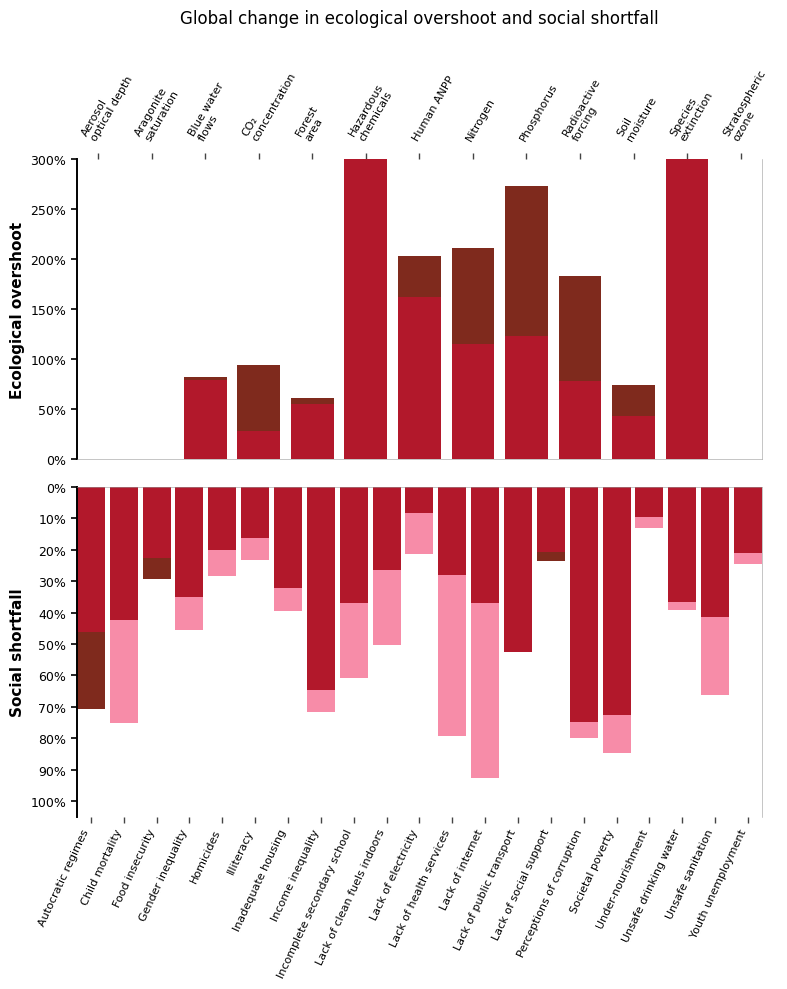

In [1379]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

base_red        = "#b2182b"
increase_brown  = "#7f2a1d"
reduction_pink  = "#f78ca8"
cap_dark        = "#5c0f0d"

percent_fmt = FuncFormatter(lambda v, pos: f"{int(v)}%")

fig, (ax_eco, ax_soc) = plt.subplots(
    2, 1,
    figsize=(8, 10),
    gridspec_kw={"height_ratios": [1, 1.1]}
)

fig.patch.set_facecolor("white")

# ===============================================================
# ================= TOP PANEL: ECOLOGICAL OVERSHOOT =============
# ===============================================================

x_eco = np.arange(len(eco_plot))

ax_eco.bar(x_eco, eco_plot["start_plot"],
           color=base_red, width=0.8, edgecolor="none")

ax_eco.bar(x_eco, eco_plot["change_plot"],
           bottom=eco_plot["start_plot"],
           color=increase_brown, width=0.8, edgecolor="none")

ax_eco.set_ylim(0, 300)
ax_eco.yaxis.set_major_formatter(percent_fmt)
ax_eco.set_ylabel("Ecological overshoot", fontsize=11, fontweight="bold")

ax_eco.set_xticks(x_eco)
ax_eco.set_xticklabels(
    eco_plot["label"], rotation=60, ha="left",
    rotation_mode="anchor", fontsize=8
)

ax_eco.xaxis.tick_top()
ax_eco.tick_params(
    axis="x",
    top=True, bottom=False,
    labeltop=True, labelbottom=False,
    length=4, width=1.0, color="#444444",
    pad=8, labelsize=8,
)

ax_eco.spines["left"].set_color("black")
ax_eco.spines["left"].set_linewidth(1.4)

ax_eco.tick_params(
    axis="y",
    length=4, width=1.2,
    color="black",
    labelsize=9
)
ax_eco.margins(x=0)
ax_eco.set_axisbelow(True)
ax_eco.spines["top"].set_visible(False)
ax_eco.spines["right"].set_visible(True)
ax_eco.spines["right"].set_linewidth(0.4)
ax_eco.spines["right"].set_color("#999999")

ax_eco.spines["bottom"].set_color("#999999")
ax_eco.spines["bottom"].set_linewidth(0.4)

ax_eco.set_title(
    "Global change in ecological overshoot and social shortfall",
    fontsize=12, pad=30
)

# ===============================================================
# ================= BOTTOM PANEL: SOCIAL SHORTFALL ==============
# ===============================================================

x_soc = np.arange(len(social_plot))

ax_soc.bar(x_soc, -social_plot["start_plot"],
           color=base_red, width=0.85, edgecolor="none")

ax_soc.bar(x_soc, -social_plot["increase"],
           bottom=-social_plot["start_plot"],
           color=increase_brown, width=0.85, edgecolor="none")

for xi, base, inc in zip(x_soc, social_plot["start_plot"], social_plot["increase"]):
    if inc > 0:
        ax_soc.bar(
            xi, -0.01,
            bottom=-(base + inc),
            color=cap_dark, width=0.85, edgecolor="none"
        )

ax_soc.bar(
    x_soc, social_plot["reduction"],
    bottom=-social_plot["start_plot"],
    color=reduction_pink, width=0.85, edgecolor="none"
)

ax_soc.set_ylim(-105, 0)
ax_soc.margins(x=0)
ax_soc.spines["top"].set_visible(True)
ax_soc.spines["top"].set_position(("data", 0))
ax_soc.spines["top"].set_color("#999999")
ax_soc.spines["top"].set_linewidth(0.4)

ax_soc.spines["bottom"].set_visible(False)

ax_soc.spines["right"].set_visible(True)
ax_soc.spines["right"].set_linewidth(0.4)
ax_soc.spines["right"].set_color("#999999")

ax_soc.spines["left"].set_color("black")
ax_soc.spines["left"].set_linewidth(1.4)

ax_soc.tick_params(
    axis="y",
    length=4, width=1.2,
    color="black",
    labelsize=9
)

ax_soc.set_ylabel("Social shortfall", fontsize=11, fontweight="bold")
ax_soc.set_yticks(np.arange(-100, 1, 10))
ax_soc.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{abs(int(v))}%"))

ax_soc.set_axisbelow(True)

ax_soc.set_xticks(x_soc)
ax_soc.set_xticklabels(
    social_plot["label"], rotation=65, ha="right", fontsize=8
)

ax_soc.tick_params(
    axis="x",
    bottom=True, top=False,
    labelbottom=True, labeltop=False,
    length=4, width=1.0, color="#444444"
)

plt.tight_layout()
plt.show()


## 6. Doughnut Chart Visualization

This section creates an interactive doughnut chart that visualizes both the social foundation and ecological ceiling simultaneously. The chart displays:

- **Social Foundation (inner ring)**: Shows social shortfall indicators across 12 dimensions, with values proportional to the area of each bar
- **Ecological Ceiling (outer ring)**: Shows ecological overshoot indicators across 9 dimensions, scaled appropriately to fit within the visualization

The visualization uses Altair to create an interactive chart where:
- Each social indicator is represented in the inner ring
- Each ecological indicator is represented in the outer ring  
- Dimension labels are placed radially around the chart
- Values are proportional to bar area (not length) to provide accurate visual representation of relative magnitudes



In [1380]:
import numpy as np
import pandas as pd
import altair as alt
import math
import re


# Filter for social domain, World data, and get the latest year (2022), from the global data file
social_df = global_2000_2022_df[
    (global_2000_2022_df["domain"] == "social") &
    (global_2000_2022_df["group"] == "World") &
    (global_2000_2022_df["date"] == 2022) &
    (global_2000_2022_df["value"].notna())
].copy()

# Use the 'value' column from global_2000_2022.csv for social shortfall
social_df["ratioEnd"] = social_df["value"].copy()
social_df["valueEnd"] = social_df["value"].copy()

In [1381]:
# Filter for ecological domain, World data, and get the latest year (2022), from the global data file
eco_df = global_2000_2022_df[
    (global_2000_2022_df["domain"] == "ecological") &
    (global_2000_2022_df["group"] == "World") &
    (global_2000_2022_df["date"] == 2022) &
    (global_2000_2022_df["shortfallOvershoot_pct"].notna())
].copy()

# Use shortfallOvershoot_pct/100 for ecological overshoot
eco_df["ratioEnd"] = eco_df["shortfallOvershoot_pct"]
eco_df["valueEnd"] = eco_df["value"].copy()

In [1382]:
import altair as alt
import numpy as np
import pandas as pd
import re

# =============================================================================
#  SOCIAL FOUNDATION DATA & ANGLES
# =============================================================================

dimension_order = [
    "food", "health", "education", "income and work",
    "peace and justice", "political voice", "social cohesion",
    "equality", "housing", "connectivity", "energy", "water"
]

# Order social dimensions and indicators around the circle
social_df["dimension"] = pd.Categorical(
    social_df["dimension"], categories=dimension_order, ordered=True
)
social_df = social_df.sort_values(["dimension", "indicator"]).reset_index(drop=True)

total_indicators = len(social_df)
indicator_angle_width = 360 / total_indicators

social_df["indicator_index"] = social_df.index
social_df["indicator_angle"] = social_df["indicator_index"] * indicator_angle_width
social_df["indicator_angle2"] = social_df["indicator_angle"] + indicator_angle_width

# Angle span per social dimension
dim_angle_map = (
    social_df.groupby("dimension")["indicator_angle"]
    .agg(["min", "max"])
    .reset_index()
    .rename(columns={"min": "angle_min", "max": "angle_max"})
)

# =============================================================================
#  RADIAL LAYOUT CONSTANTS
# =============================================================================

R_MAX_RADIUS = 90  # overall outer radius of the chart

# Social bars (inner part)
SOCIAL_BARS_TOP_R       = 20   # social bars end at the social foundation ring
SOCIAL_BARS_INNER_MIN_R = 6    # minimum inner radius of social bars

# Social foundation ring (inner dark-green)
SOCIAL_FOUNDATION_INNER_R = SOCIAL_BARS_TOP_R
SOCIAL_FOUNDATION_OUTER_R = SOCIAL_BARS_TOP_R + 2

# Medium ring (light-green band)
MEDIUM_RING_INNER_R = SOCIAL_FOUNDATION_OUTER_R
MEDIUM_RING_OUTER_R = 26

# Ecological ceiling ring (outer dark-green band)
ECO_CEILING_INNER_R = MEDIUM_RING_OUTER_R
ECO_CEILING_OUTER_R = MEDIUM_RING_OUTER_R + 2

# Ecological bars (outer part)
ECO_BARS_INNER_R     = ECO_CEILING_OUTER_R
ECO_BARS_OUTER_MAX_R = R_MAX_RADIUS

BAR_TOP = SOCIAL_FOUNDATION_INNER_R
bar_inner_edge_min = SOCIAL_BARS_INNER_MIN_R

# =============================================================================
#  SOCIAL BARS: AREA-BASED HEIGHTS & TOOLTIP LABELS
# =============================================================================

# normalize to [0, 1]
social_df["ratioEnd"] = social_df["ratioEnd"].fillna(0).clip(lower=0)
ratio_norm = social_df["ratioEnd"] / 100.0

# Area-based mapping: area ∝ value
# (π * r_outer^2 * Δθ / 360) * ratio_norm = π * (r_outer^2 - r_inner^2) * Δθ / 360
# ⇒ r_inner^2 = r_outer^2 * (1 - ratio_norm)
social_df["bar_inner_radius_sq"] = BAR_TOP**2 * (1 - ratio_norm)
social_df["bar_inner_radius"] = np.sqrt(social_df["bar_inner_radius_sq"]).clip(
    lower=bar_inner_edge_min, upper=BAR_TOP
)

# Zero value ⇒ bar collapses to the top ring
social_df.loc[social_df["ratioEnd"] == 0, "bar_inner_radius"] = BAR_TOP

social_df["bar_outer_radius"] = BAR_TOP
social_df["bar_inner_radius"] = np.minimum(
    social_df["bar_inner_radius"], BAR_TOP - 0.001
)


def format_indicator(ind):
    """Split camelCase / PascalCase into words and title-case them."""
    formatted = re.sub(r"([a-z])([A-Z])", r"\1 \2", ind)
    return formatted.title()


social_df["indicator_label"] = (
    social_df["indicator"].map(name_map)
    .fillna(social_df["indicator"].apply(format_indicator))
)
social_df["tooltip_text"] = (
    social_df["indicator_label"]
    + ": "
    + social_df["ratioEnd"].round(2).astype(str)
    + "%"
)

social_bars_chart = alt.Chart(social_df).mark_arc(strokeWidth=0).encode(
    theta=alt.Theta("indicator_angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("indicator_angle2:Q"),
    radius=alt.Radius("bar_inner_radius:Q"),
    radius2=alt.Radius2("bar_outer_radius:Q"),
    color=alt.Color(
        "ratioEnd:Q",
        scale=alt.Scale(
            domain=[social_df["ratioEnd"].min(), social_df["ratioEnd"].max()],
            range=["#E6A3B7", "#5A224A"],
        ),
        legend=None,
    ),
    tooltip=[alt.Tooltip("tooltip_text:N", title=" ")],
)

# =============================================================================
#  SOCIAL RINGS (FOUNDATION, MEDIUM) & BACKGROUND TRIANGLES
# =============================================================================

# Social foundation ring (inner dark-green)
social_foundation_data = pd.DataFrame(
    {
        "angle": [0],
        "angle2": [360],
        "inner_r": [SOCIAL_FOUNDATION_INNER_R],
        "outer_r": [SOCIAL_FOUNDATION_OUTER_R],
    }
)

social_foundation_ring_chart = alt.Chart(social_foundation_data).mark_arc(
    strokeWidth=0
).encode(
    theta=alt.Theta("angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("angle2:Q"),
    radius=alt.Radius("inner_r:Q"),
    radius2=alt.Radius2("outer_r:Q"),
    color=alt.value("#2E7D32"),
)

# Medium ring (light-green band)
medium_ring_data = pd.DataFrame(
    {
        "angle": [0],
        "angle2": [360],
        "inner_r": [MEDIUM_RING_INNER_R],
        "outer_r": [MEDIUM_RING_OUTER_R],
    }
)

medium_ring_chart = alt.Chart(medium_ring_data).mark_arc(strokeWidth=0).encode(
    theta=alt.Theta("angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("angle2:Q"),
    radius=alt.Radius("inner_r:Q"),
    radius2=alt.Radius2("outer_r:Q"),
    color=alt.value("#6EB446"),
)

# Background bands for each social dimension
dim_triangles_base = dim_angle_map[["dimension", "angle_min", "angle_max"]].copy()
dim_triangles_base["triangle_angle"] = dim_triangles_base["angle_min"]
dim_triangles_base["triangle_angle2"] = (
    dim_triangles_base["angle_max"] + indicator_angle_width
)

triangle_layers = []
num_layers = 8

for i in range(num_layers):
    layer_data = dim_triangles_base.copy()
    layer_data["triangle_radius_inner"] = (BAR_TOP * i) / num_layers
    layer_data["triangle_radius_outer"] = (BAR_TOP * (i + 1)) / num_layers

    progress = (i + 1) / num_layers
    layer_opacity = 0.25 * (progress**1.3)

    triangle_layers.append(
        alt.Chart(layer_data)
        .mark_arc(strokeWidth=0, fill="#F7D6D8", opacity=layer_opacity)
        .encode(
            theta=alt.Theta("triangle_angle:Q", scale=alt.Scale(domain=[0, 360])),
            theta2=alt.Theta2("triangle_angle2:Q"),
            radius=alt.Radius("triangle_radius_inner:Q"),
            radius2=alt.Radius2("triangle_radius_outer:Q"),
        )
    )

dim_triangles_chart = triangle_layers[0]
for lyr in triangle_layers[1:]:
    dim_triangles_chart = dim_triangles_chart + lyr

# Social dimension separators
dim_boundaries = social_df.groupby("dimension").first().reset_index()
dim_boundaries["boundary_angle"] = dim_boundaries["indicator_angle"].astype(float)
dim_boundaries["boundary_angle2"] = dim_boundaries["boundary_angle"] + 0.5
dim_boundaries["separator_radius_inner"] = 3
dim_boundaries["separator_radius_outer"] = BAR_TOP

dim_separators_chart = alt.Chart(dim_boundaries).mark_arc(
    stroke="white", strokeWidth=4, fill="transparent"
).encode(
    theta=alt.Theta("boundary_angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("boundary_angle2:Q"),
    radius=alt.Radius("separator_radius_inner:Q"),
    radius2=alt.Radius2("separator_radius_outer:Q"),
)

# =============================================================================
#  SOCIAL DIMENSION LABELS
# =============================================================================

label_data = dim_angle_map[["dimension", "angle_min", "angle_max"]].copy()
label_data["label_angle"] = (label_data["angle_min"] + label_data["angle_max"]) / 2
label_data["label_angle"] = label_data["label_angle"] + 12

# Place labels in the middle of the medium ring
label_data["label_radius"] = SOCIAL_FOUNDATION_OUTER_R + (
    MEDIUM_RING_OUTER_R - SOCIAL_FOUNDATION_OUTER_R
) * 0.55

label_data["dimension_label"] = label_data["dimension"].str.title()
label_data["dimension_index"] = range(len(label_data))


def social_label_rotation(row):
    """Progressive rotation correction"""
    angle = row["label_angle"] % 360
    text_angle = angle - 90
    correction = row["dimension_index"] * 14
    text_angle =  text_angle + correction
    return text_angle


label_data["text_angle"] = label_data.apply(social_label_rotation, axis=1)

labels_chart = (
    alt.Chart(label_data)
    .mark_text(
        align="center",
        baseline="middle",
        fontSize=10,
        fontWeight="normal",
        fill="white",
        font="Times",
    )
    .encode(
        theta=alt.Theta("label_angle:Q", scale=alt.Scale(domain=[0, 360])),
        radius=alt.Radius("label_radius:Q"),
        text=alt.Text("dimension_label:N"),
        angle=alt.Angle("text_angle:Q"),
    )
)

# =============================================================================
#  ECOLOGICAL CEILING DATA & ANGLES
# =============================================================================

eco_dimension_order = [
    "climate change", "ozone depletion", "ocean acidification",
    "chemical pollution", "nutrient pollution", "air pollution",
    "freshwater disruption", "land conversion", "biodiversity breakdown",
]

eco_df["dimension"] = pd.Categorical(
    eco_df["dimension"], categories=eco_dimension_order, ordered=True
)
eco_df = eco_df.sort_values(["dimension", "indicator"]).reset_index(drop=True)

total_eco_indicators = len(eco_df)
eco_indicator_angle_width = 360 / total_eco_indicators

eco_df["indicator_index"] = eco_df.index

BAR_WIDTH_FRAC = 1.0  # fraction of each slot actually used by bars

# Initial approximate angles (used to get per-dimension spans)
eco_df["indicator_center_angle"] = (
    eco_df["indicator_index"] + 0.5
) * eco_indicator_angle_width

half_span = (eco_indicator_angle_width * BAR_WIDTH_FRAC) / 2
eco_df["indicator_angle"] = eco_df["indicator_center_angle"] - half_span
eco_df["indicator_angle2"] = eco_df["indicator_center_angle"] + half_span

eco_dim_angle_map = (
    eco_df.groupby("dimension")["indicator_angle"]
    .agg(["min", "max"])
    .reset_index()
    .rename(columns={"min": "angle_min", "max": "angle_max"})
)

eco_dim_angle_map["angle"] = (
    eco_dim_angle_map["angle_min"] + eco_dim_angle_map["angle_max"]
) / 2

eco_df = eco_df.merge(
    eco_dim_angle_map[["dimension", "angle"]], on="dimension"
)

# =============================================================================
#  ECO BAR NARROWING (PER DIMENSION)
# =============================================================================

SHRINK = 1.0  # 1.0 → no angular shrink, <1.0 → narrower bars within each dimension


def assign_dimension_angles(group):
    """Re-assign angles inside each dimension cluster, keeping them centered."""
    n = len(group)
    dim_center = group["angle"].iloc[0]

    base_width = 360.0 / total_eco_indicators
    local_width = base_width * SHRINK
    total_width = n * local_width

    start_angle = dim_center - total_width / 2.0
    idx = np.arange(n)

    group["indicator_angle"] = start_angle + idx * local_width
    group["indicator_angle2"] = group["indicator_angle"] + local_width
    return group


eco_df = eco_df.groupby("dimension", group_keys=False).apply(assign_dimension_angles)

# =============================================================================
#  ECOLOGICAL BARS (AREA-BASED HEIGHTS) & TOOLTIP LABELS
# =============================================================================

eco_df["overshoot_pct"] = eco_df["ratioEnd"].fillna(0).clip(lower=0)
OVERSHOOT_CAP = 650.0  # overshoot values above this are capped
eco_df["overshoot_pct"] = eco_df["overshoot_pct"].clip(upper=OVERSHOOT_CAP)

AREA_SHRINK = 0.40  # shrinks the effective area scale so petals don't dominate chart

max_val_eco = eco_df["overshoot_pct"].max()
if max_val_eco <= 0:
    max_val_eco = 1.0

r0 = ECO_BARS_INNER_R
r0_sq = r0**2
r_max_sq = ECO_BARS_OUTER_MAX_R**2

# Base area scale so max indicator reaches max radius (before shrinking)
k_full = (r_max_sq - r0_sq) / max_val_eco

# Apply shrink factor inside the area equation
k = AREA_SHRINK * k_full

# Area-preserving mapping: r_outer^2 = r0^2 + k * overshoot
eco_df["bar_outer_radius_sq"] = r0_sq + k * eco_df["overshoot_pct"]
eco_df["bar_outer_radius_sq"] = eco_df["bar_outer_radius_sq"].clip(upper=r_max_sq)
eco_df["bar_outer_radius"] = np.sqrt(eco_df["bar_outer_radius_sq"])

eco_df["bar_inner_radius"] = r0
eco_df.loc[eco_df["overshoot_pct"] <= 0, "bar_outer_radius"] = r0

# Safety clip to global outer radius
eco_df["bar_outer_radius"] = eco_df["bar_outer_radius"].clip(
    upper=ECO_BARS_OUTER_MAX_R
)

eco_df["indicator_label"] = (
    eco_df["indicator"].map(name_map)
    .fillna(eco_df["indicator"].apply(format_indicator))
)
eco_df["tooltip_text"] = (
    eco_df["indicator_label"]
    + ": "
    + eco_df["ratioEnd"].round(2).astype(str)
    + "%"
)

eco_bars_chart = alt.Chart(eco_df).mark_arc(strokeWidth=0).encode(
    theta=alt.Theta("indicator_angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("indicator_angle2:Q"),
    radius=alt.Radius("bar_inner_radius:Q"),
    radius2=alt.Radius2("bar_outer_radius:Q"),
    color=alt.Color(
        "ratioEnd:Q",
        scale=alt.Scale(
            domain=[eco_df["ratioEnd"].min(), eco_df["ratioEnd"].max()],
            range=["#E6A3B7", "#5A224A"],
        ),
        legend=None,
    ),
    tooltip=[alt.Tooltip("tooltip_text:N", title=" ")],
)

# Ecological ceiling ring (outer dark-green band)
ecological_ceiling_data = pd.DataFrame(
    {
        "angle": [0],
        "angle2": [360],
        "inner_r": [ECO_CEILING_INNER_R],
        "outer_r": [ECO_CEILING_OUTER_R],
    }
)

ecological_ceiling_ring_chart = alt.Chart(ecological_ceiling_data).mark_arc(
    strokeWidth=0
).encode(
    theta=alt.Theta("angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("angle2:Q"),
    radius=alt.Radius("inner_r:Q"),
    radius2=alt.Radius2("outer_r:Q"),
    color=alt.value("#2E7D32"),
)

# =============================================================================
#  ECOLOGICAL DIMENSION LABELS & SEPARATORS
# =============================================================================

# Use final bar angles to compute label centers (circular mean)
eco_centers = eco_df.copy()
eco_centers["center_angle"] = (
    eco_centers["indicator_angle"].astype(float)
    + eco_centers["indicator_angle2"].astype(float)
) / 2.0


def circular_mean_deg(series):
    """Circular mean of angles in degrees (handles 0/360 wrap)."""
    radians = np.deg2rad(series.to_numpy().astype(float))
    sin_mean = np.sin(radians).mean()
    cos_mean = np.cos(radians).mean()
    angle = np.degrees(np.arctan2(sin_mean, cos_mean))
    if angle < 0:
        angle += 360
    return angle


eco_label_centers = (
    eco_centers.groupby("dimension")["center_angle"]
    .apply(circular_mean_deg)
    .reset_index(name="label_angle")
)

eco_label_centers["dimension_index"] = range(len(eco_label_centers))

# Build stacked-word rows (top/bottom word arrangement per dimension)
rows = []
base_offset = 1.8   # distance from ECO_CEILING_OUTER_R
line_spacing = 0.45  # radial spacing between stacked lines

for _, row in eco_label_centers.iterrows():
    dim = row["dimension"]
    label_angle = row["label_angle"]
    dim_index = row["dimension_index"]

    words = dim.lower().split()

    if len(words) == 1:
        rows.append(
            {
                "dimension_label": words[0],
                "label_angle": label_angle,
                "label_radius": ECO_CEILING_OUTER_R + base_offset,
                "dimension_index": dim_index,
            }
        )
    else:
        # First word further out (top)
        rows.append(
            {
                "dimension_label": words[0],
                "label_angle": label_angle,
                "label_radius": ECO_CEILING_OUTER_R + base_offset + line_spacing,
                "dimension_index": dim_index,
            }
        )
        # Remaining words closer to ring (bottom)
        rows.append(
            {
                "dimension_label": " ".join(words[1:]),
                "label_angle": label_angle,
                "label_radius": ECO_CEILING_OUTER_R + base_offset - line_spacing,
                "dimension_index": dim_index,
            }
        )

eco_label_data = pd.DataFrame(rows)


def flip_bottom_with_correction(row):
    """Rotation with progressive correction"""
    angle = row["label_angle"]
    text_angle = angle - 90
    correction = row["dimension_index"] * 15
    text_angle =  text_angle + correction
    return text_angle


eco_label_data["text_angle"] = eco_label_data.apply(
    flip_bottom_with_correction, axis=1
)


eco_darkness_map = eco_df.groupby('dimension')['overshoot_pct'].max().to_dict()

# Add text color based on the dimension's darkness
DARKNESS_THRESHOLD = 600

def get_text_color(dim_index):
    dimension = eco_label_centers.iloc[dim_index]['dimension']
    overshoot = eco_darkness_map.get(dimension, 0)
    return 'white' if overshoot > DARKNESS_THRESHOLD else 'black'

eco_label_data['text_color'] = eco_label_data['dimension_index'].apply(get_text_color)

eco_labels_chart = alt.Chart(eco_label_data).mark_text(
    align="center",
    baseline="middle",
    fontSize=11,
    fontWeight="normal",
    font="Times",
    fontStyle="italic",
).encode(
    theta=alt.Theta("label_angle:Q", scale=alt.Scale(domain=[0, 360])),
    radius=alt.Radius("label_radius:Q"),
    text=alt.Text("dimension_label:N"),
    angle=alt.Angle("text_angle:Q"),
    color=alt.Color("text_color:N", scale=None, legend=None),  # Changed this line
)

# Ecological dimension separators
eco_dim_boundaries = eco_df.groupby("dimension").first().reset_index()
eco_dim_boundaries["boundary_angle"] = eco_dim_boundaries["indicator_angle"].astype(
    float
)
eco_dim_boundaries["boundary_angle2"] = eco_dim_boundaries["boundary_angle"] + 0.5
eco_dim_boundaries["separator_radius_inner"] = ECO_CEILING_OUTER_R
eco_dim_boundaries["separator_radius_outer"] = ECO_BARS_OUTER_MAX_R

eco_dim_separators_chart = alt.Chart(eco_dim_boundaries).mark_arc(
    stroke="white", strokeWidth=5, fill="transparent"
).encode(
    theta=alt.Theta("boundary_angle:Q", scale=alt.Scale(domain=[0, 360])),
    theta2=alt.Theta2("boundary_angle2:Q"),
    radius=alt.Radius("separator_radius_inner:Q"),
    radius2=alt.Radius2("separator_radius_outer:Q"),
)

# =============================================================================
#  RING LABELS: CURVED "SOCIAL FOUNDATION" & "ECOLOGICAL CEILING"
# =============================================================================

def create_curved_text(text, radius, start_angle=0, color="white"):
    """
    Place characters along a circle of given radius.
    Each character gets a small angular step so the word follows the curve.
    """
    chars = list(text)
    char_spacing = 100 / radius  # simple heuristic spacing
    angles = [start_angle + i * char_spacing for i in range(len(chars))]

    char_data = []
    for char, angle in zip(chars, angles):
        # Make letters roughly tangent to the circle
        text_angle = (angle - 90) if angle <= 180 else (angle - 90 + 180)
        char_data.append(
            {
                "char": char,
                "angle": angle,
                "text_angle": text_angle,
                "radius": radius,
                "color": color,
            }
        )
    return pd.DataFrame(char_data)


social_text = create_curved_text(
    "SOCIAL FOUNDATION",
    (SOCIAL_FOUNDATION_INNER_R + SOCIAL_FOUNDATION_OUTER_R) / 2,
    start_angle=0,
    color="white",
)

eco_text = create_curved_text(
    "ECOLOGICAL CEILING",
    (ECO_CEILING_INNER_R + ECO_CEILING_OUTER_R) / 2,
    start_angle=0,
    color="white",
)

ring_labels_df = pd.concat([social_text, eco_text], ignore_index=True)

ring_labels_chart = alt.Chart(ring_labels_df).mark_text(
    align="center",
    baseline="middle",
    fontSize=12,
    fontWeight="bold",
    font="Times",
).encode(
    theta=alt.Theta("angle:Q", scale=alt.Scale(domain=[0, 360])),
    radius=alt.Radius("radius:Q"),
    text=alt.Text("char:N"),
    angle=alt.Angle("text_angle:Q"),
    color=alt.Color("color:N", scale=None, legend=None),
    opacity=alt.value(0.8),
)

# =============================================================================
#  FINAL COMPOSITION
# =============================================================================

chart = (
    dim_triangles_chart
    + social_bars_chart
    + dim_separators_chart
    + social_foundation_ring_chart
    + medium_ring_chart
    + eco_bars_chart
    + eco_dim_separators_chart
    + ecological_ceiling_ring_chart
    + labels_chart
    + eco_labels_chart
    + ring_labels_chart
).properties(
    width=710,
    height=710,
).resolve_scale(
    color="independent"
).configure(
    padding=130
).configure_view(
    strokeWidth=0,
    fill="white",
    continuousWidth=2700,
    continuousHeight=2700,
)

spec = chart.to_dict()
spec["autosize"] = {"type": "none", "contains": "padding"}
chart = alt.Chart.from_dict(spec)

chart


C:\Users\Admin\AppData\Local\Temp\ipykernel_11956\1695925262.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  social_df.groupby("dimension")["indicator_angle"]
C:\Users\Admin\AppData\Local\Temp\ipykernel_11956\1695925262.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dim_boundaries = social_df.groupby("dimension").first().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11956\1695925262.py:293: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

alt.LayerChart(...)